In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from optuna.distributions import CategoricalDistribution
%matplotlib inline
import seaborn as sns

%precision %.4f

import warnings

warnings.filterwarnings('ignore')

### Описание датасета и разведочный анализ
Сам [датасет](https://www.kaggle.com/datasets/shivachandel/kc-house-data?resource=download).
Описание датасета:
- id - идентификатор
- date - дата продажи
- price (целевой признак) - стоимость дома
- bedrooms - количество спален
- bathrooms - количество ванных комнат
- sqft_living - размер жилой площади в квадратных футах
- sqft_lot - размер участка в квадратных футах
- floors - количество этажей
- waterfront - наличие набережной
- view - показатель от 0 до 4, показывающий, насколько хорошим был вид на объект недвижимости
- condition - состояние дома, оцененное от 1 до 5
- grade - классификация по качеству конструкции, которая относится к типам используемых материалов и качеству изготовления
- sqft_above - квадратных футов над землей
- sqft_basmt - квадратных футов под землей
- yr_built - год постройки
- yr_renovated - год последнего ремонта. 0, если никогда
- zipcode - 5-значный почтовый индекс
- lat - широта
- long - долгота
- sqft_living15 - средний размер внутренней жилой площади для ближайших 15 домов, в квадратных футах
- sqft_lot15 - средний размер земельных участков для ближайших 15 домов, в квадратных футах

Наобходимо решить задачу регрессии, предсказать целевой признак price по нецелевым.

In [2]:
df = pd.read_csv('kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180.0,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170.0,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770.0,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050.0,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680.0,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
df.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       2
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

В признаке `sqft_above` есть два пропущенных значения. Относительно общего количества данных это значение кажется небольшим, так что просто удалим.

In [4]:
df.dropna(subset=['sqft_above'], inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21611 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21611 non-null  int64  
 1   date           21611 non-null  object 
 2   price          21611 non-null  float64
 3   bedrooms       21611 non-null  int64  
 4   bathrooms      21611 non-null  float64
 5   sqft_living    21611 non-null  int64  
 6   sqft_lot       21611 non-null  int64  
 7   floors         21611 non-null  float64
 8   waterfront     21611 non-null  int64  
 9   view           21611 non-null  int64  
 10  condition      21611 non-null  int64  
 11  grade          21611 non-null  int64  
 12  sqft_above     21611 non-null  float64
 13  sqft_basement  21611 non-null  int64  
 14  yr_built       21611 non-null  int64  
 15  yr_renovated   21611 non-null  int64  
 16  zipcode        21611 non-null  int64  
 17  lat            21611 non-null  float64
 18  long  

Признак `date` имеет тип данных `object`, что не позволит с ним работать, поэтому будет необходимо дополнительно  обработать этот признак.

In [6]:
df.nunique().sort_values()

waterfront           2
view                 5
condition            5
floors               6
grade               12
bedrooms            13
bathrooms           30
zipcode             70
yr_renovated        70
yr_built           116
sqft_basement      306
date               372
long               752
sqft_living15      777
sqft_above         946
sqft_living       1038
price             4028
lat               5034
sqft_lot15        8689
sqft_lot          9782
id               21434
dtype: int64

#### Целевой признак price - цена дома.

In [7]:
df['price'].describe()

count    2.161100e+04
mean     5.400850e+05
std      3.671430e+05
min      7.500000e+04
25%      3.217250e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

Не очень удобно оперировать в долларах, поэтому переведем цену дома в тысячи долларов.

In [8]:
df['price'] /= 1000
df['price'].describe()

count    21611.000000
mean       540.085027
std        367.143049
min         75.000000
25%        321.725000
50%        450.000000
75%        645.000000
max       7700.000000
Name: price, dtype: float64

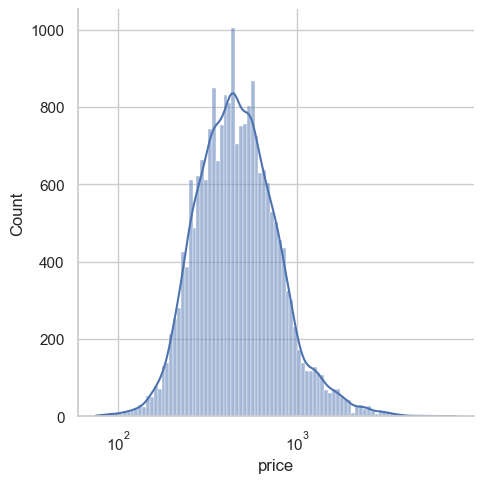

In [9]:
sns.set(style='whitegrid')
ax = sns.displot(x='price', data=df, kde=True, log_scale=True, color='b')

#### Количественный признак date - дата продажи.

In [10]:
df['date'].describe()

count               21611
unique                372
top       20140623T000000
freq                  142
Name: date, dtype: object

Так как тип - `object`, данный признак для дальнейшей работы необходимо преобразовать либо убрать.
По личным соображениям цена дома вполне может зависеть от даты продажи, поэтому полностью удалять кажется нецелесообразным.

Простым выходом кажется разбить общую дату на три столбца - `year`, `month`, `day`. Однако сам `day` мало что говорит, возможно, было бы полезнее рассматривать именно праздничные дни, но пока что ограничимся годом и месяцем.

In [11]:
df['year'] = pd.to_datetime(df['date']).dt.year
df['month'] = pd.to_datetime(df['date']).dt.month
df.drop(columns=['date'], inplace=True)

In [12]:
df['year'].value_counts()

2014    14632
2015     6979
Name: year, dtype: int64

Видимо, в датасете присутствуют данные лишь за 2014 и 2015 год, так что заменим на 0 и 1.

In [13]:
df['year_cat'] = 0
df.loc[df['year'] == 2015, 'year_cat'] = 1
df.drop(columns=['year'], inplace=True)

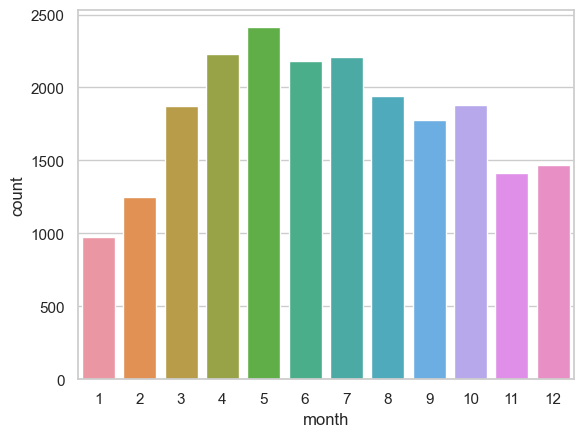

In [14]:
sns.countplot(df, x='month');

Таким образом, чаще всего дома покупали весной (апрель, май) и летом (июнь, июль), реже всего - зимой.

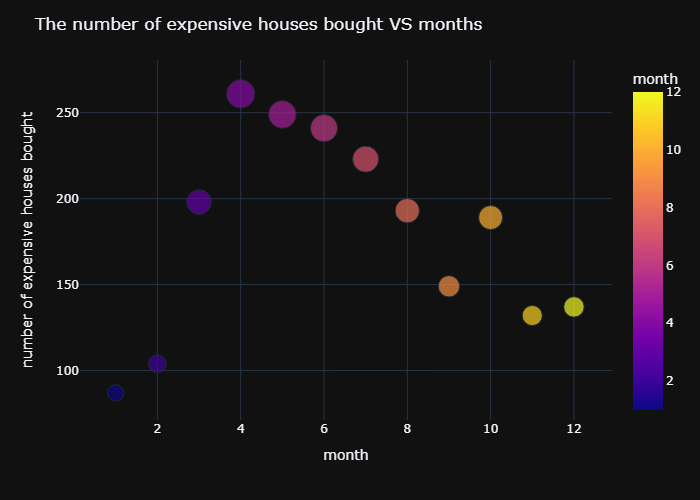

In [15]:
from _plotly_utils.colors.sequential import Viridis
from plotly.express import scatter

quantile = df['price'].quantile(q=0.9)
fig = scatter(df[df['price'] >= quantile].groupby('month', as_index=False).count(), x='month', y='price', color='month', size = 'price', color_discrete_sequence=Viridis)
fig.update_layout(title='The number of expensive houses bought VS months', xaxis_title='month', yaxis_title='number of expensive houses bought')
fig.show("png")

Самые дорогие дома также покупались с апреля по июнь.

#### Количественные признаки `bedrooms` и `bathrooms`

In [16]:
df['bedrooms'].describe()

count    21611.000000
mean         3.370830
std          0.930092
min          0.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         33.000000
Name: bedrooms, dtype: float64

В среднем у проданных домов было по 3 комнаты.

In [17]:
df[df['bedrooms'] > 10]

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,year_cat
8757,1773100755,520.0,11,3.00,3000,4960,2.0,0,0,3,...,600,1918,1999,98106,47.5560,-122.363,1420,4960,8,0
15870,2402100895,640.0,33,1.75,1620,6000,1.0,0,0,5,...,580,1947,0,98103,47.6878,-122.331,1330,4700,6,0


На удивление домов с очень большим количеством комнат (> 10) всего две, и обе они были проданы относительно дешево.

In [18]:
df['bathrooms'].describe()

count    21611.000000
mean         2.114791
std          0.770157
min          0.000000
25%          1.750000
50%          2.250000
75%          2.500000
max          8.000000
Name: bathrooms, dtype: float64

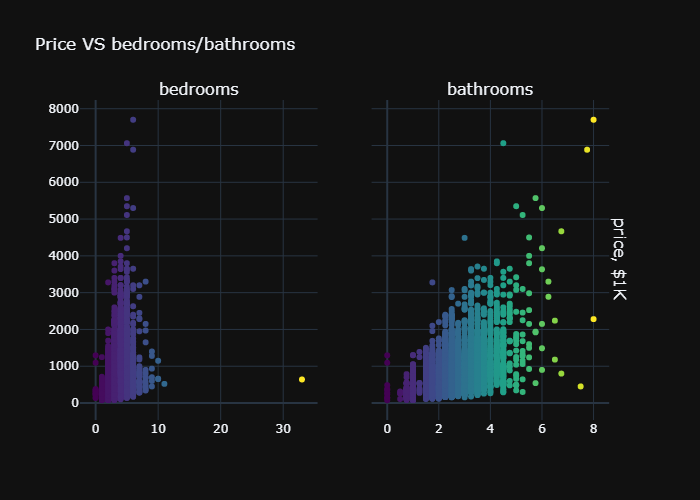

In [19]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
fig = make_subplots(rows=1, cols=2, shared_yaxes=True, column_titles=('bedrooms', 'bathrooms'), row_titles=['price, $1K'])
fig.add_trace(go.Scatter(x=df['bedrooms'],y=df['price'], mode='markers', marker=dict(colorscale='Viridis', color=df['bedrooms'])), row=1, col=1)
fig.add_trace(go.Scatter(x=df['bathrooms'],y=df['price'], mode='markers', marker=dict(colorscale='Viridis', color=df['bathrooms'])), row=1, col=2)
fig.update_layout(title_text="Price VS bedrooms/bathrooms", showlegend=False)
fig.show("png")

С увеличением количества ванных комнат цена явно растет, с увеличением комнат - не совсем.

#### Количественные признаки `sqft_living` - размер жилой площади в квадратных футах - и `sqft_living15` - среднее `sqft_living` для ближайших 15 домов

In [20]:
df['sqft_living'].describe()

count    21611.000000
mean      2079.853454
std        918.422406
min        290.000000
25%       1426.000000
50%       1910.000000
75%       2550.000000
max      13540.000000
Name: sqft_living, dtype: float64

In [21]:
df['sqft_living15'].describe()

count    21611.000000
mean      1986.559576
std        685.416548
min        399.000000
25%       1490.000000
50%       1840.000000
75%       2360.000000
max       6210.000000
Name: sqft_living15, dtype: float64

Из интересного можно заметить, что в среднем размер жилой площади продаваемых домов был выше, чем усредненный у их соседей.

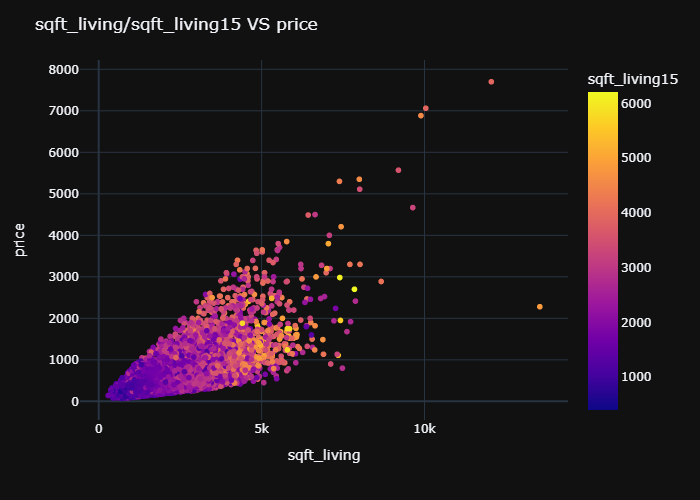

In [22]:
from _plotly_utils.colors.sequential import Viridis
from plotly.express import scatter

fig = scatter(df, x='sqft_living', y='price', color='sqft_living15', color_discrete_sequence=Viridis)
fig.update_layout(title='sqft_living/sqft_living15 VS price', xaxis_title='sqft_living', yaxis_title='price')
fig.show("png")

На графике можно увидеть, что интуитивные соображения о том, что размер жилой зоны сильно влияет на цену дома, подкрепляются данными. Также размеры жилой зоны продаваемого дома и их соседей сопоставимы.

#### Количественные признаки `sqft_lot` - размер участка в квадратных футах - и `sqft_lot15` - среднее `sqft_lot` для ближайших 15 домов

In [23]:
df['sqft_lot'].describe()

count    2.161100e+04
mean     1.510771e+04
std      4.142235e+04
min      5.200000e+02
25%      5.040000e+03
50%      7.618000e+03
75%      1.068850e+04
max      1.651359e+06
Name: sqft_lot, dtype: float64

In [24]:
df['sqft_lot15'].describe()

count     21611.000000
mean      12769.025357
std       27305.369808
min         651.000000
25%        5100.000000
50%        7620.000000
75%       10083.500000
max      871200.000000
Name: sqft_lot15, dtype: float64

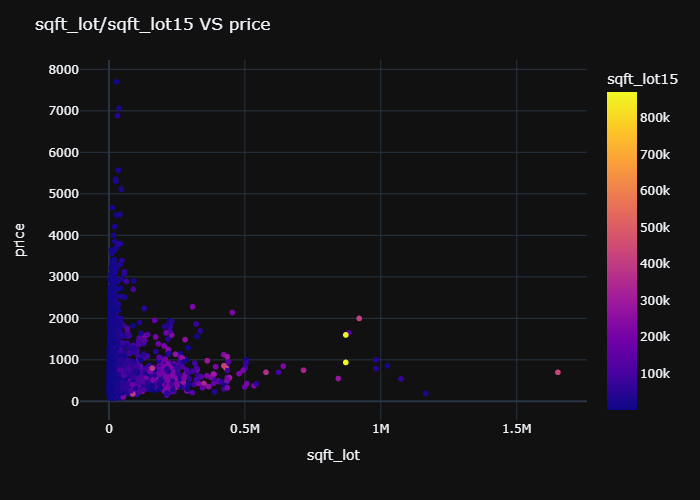

In [25]:
from _plotly_utils.colors.sequential import Viridis
from plotly.express import scatter

fig = scatter(df, x='sqft_lot', y='price', color='sqft_lot15', color_discrete_sequence=Viridis)
fig.update_layout(title='sqft_lot/sqft_lot15 VS price', xaxis_title='sqft_lot', yaxis_title='price')
fig.show("png")

Из графика не видно, чтобы размер участка особо влиял на цену.

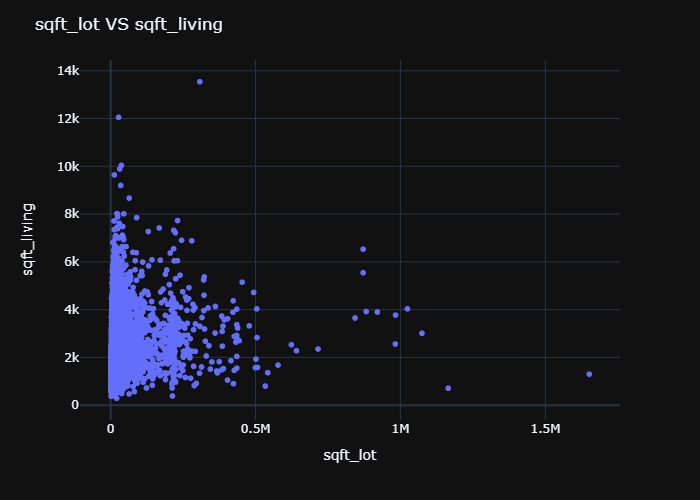

In [26]:
from plotly.express import scatter

fig = scatter(df, x='sqft_lot', y='sqft_living')
fig.update_layout(title='sqft_lot VS sqft_living', xaxis_title='sqft_lot', yaxis_title='sqft_living')
fig.show("png")

И даже не прослеживается линейной зависимости у размеров участка и размеров жилой зоны.

#### `floors` - количество этажей - и `waterfront` - наличие набережной

In [27]:
df['floors'].value_counts()

1.0    10679
2.0     8241
1.5     1909
3.0      613
2.5      161
3.5        8
Name: floors, dtype: int64

У половины людей дом был одноэтажным.

In [28]:
df['waterfront'].value_counts()

0    21448
1      163
Name: waterfront, dtype: int64

У подавляющего большинства домов не было набережной.

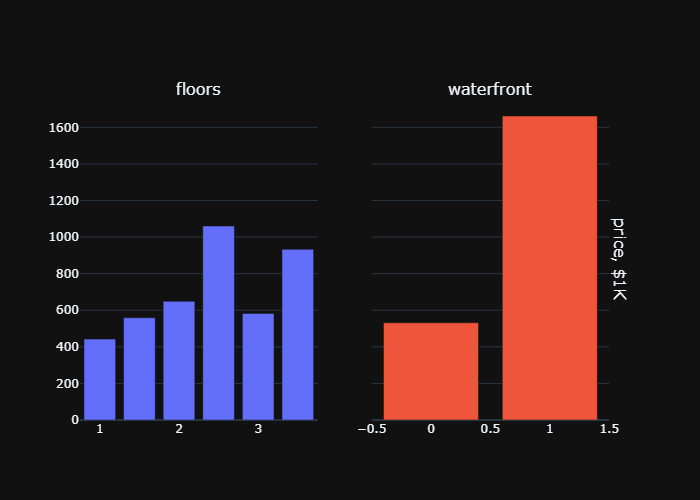

In [29]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
df_waterfront = df.groupby('waterfront', as_index=False).mean()
df_floors = df.groupby('floors', as_index=False).mean()
fig = make_subplots(rows=1, cols=2, shared_yaxes=True, column_titles=('floors', 'waterfront'), row_titles=['price, $1K'])
fig.add_trace(go.Bar(x=df_floors['floors'], y=df_floors['price']), row=1, col=1)
fig.add_trace(go.Bar(x=df_waterfront['waterfront'], y=df_waterfront['price']), row=1, col=2)
fig.update_layout(showlegend=False)
fig.show("png")

По графику зависимости цены от количества этажей самыми дорогими вышли 2,5- и 3,5-этажные дома, самая низкая стоимость - у одноэтажного.
Наличие набережной же по имеющимся данным в разы поднимает стоимость дома.

Рассмотрим корреляцию всех признаков, исключая `id` и `zipcode`, так как они очевидно не могли влиять на цену.

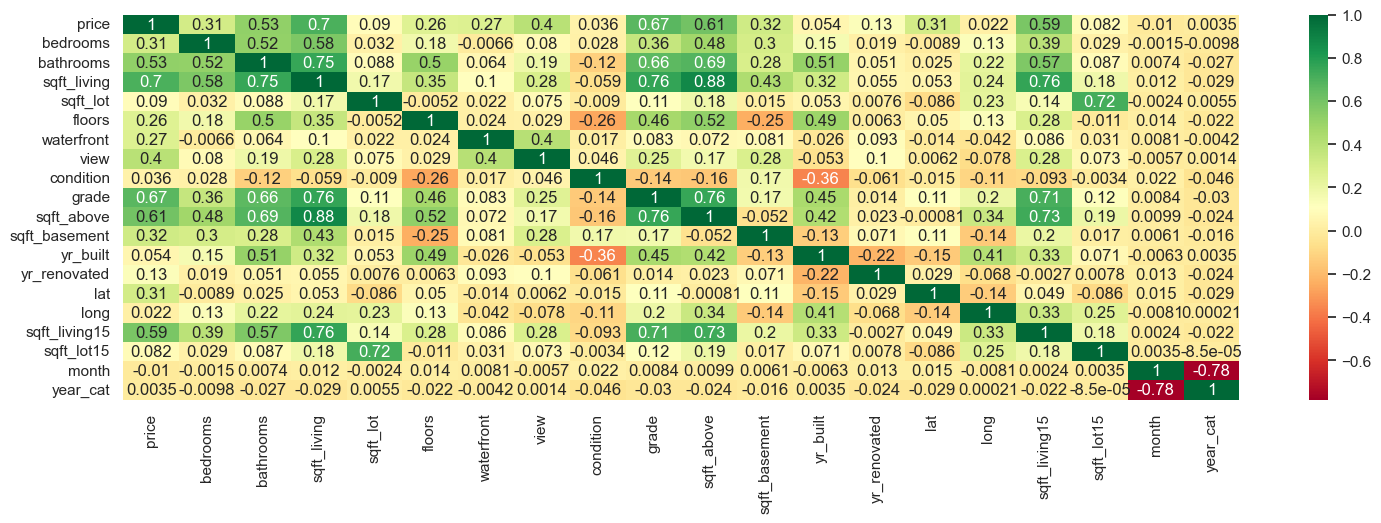

In [30]:
sns.heatmap(df.drop(columns=['id', 'zipcode']).astype(float).corr(), annot=True, cmap='RdYlGn')
fig = plt.gcf()
fig.set_size_inches(18, 5)
plt.show()

Заменим количественные признаки `yr_built` и `yr_renovated` на категориальный `repair_category`.

In [31]:
df['repair_category'] = 0

df['yr_renovated'] = df[['yr_renovated', 'yr_built']].max(axis=1)
df.loc[df['yr_renovated'] <= 1920, 'repair_category'] = 0
df.loc[(df['yr_renovated'] > 1920) & (df['yr_renovated'] <= 1940), 'repair_category'] = 1
df.loc[(df['yr_renovated'] > 1940) & (df['yr_renovated'] <= 1960), 'repair_category'] = 2
df.loc[(df['yr_renovated'] > 1960) & (df['yr_renovated'] <= 1980), 'repair_category'] = 3
df.loc[(df['yr_renovated'] > 1980) & (df['yr_renovated'] <= 2000), 'repair_category'] = 4
df.loc[(df['yr_renovated'] > 2000) & (df['yr_renovated'] <= 2010), 'repair_category'] = 5
df.loc[(df['yr_renovated'] > 2010), 'repair_category'] = 6
df.head()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,year_cat,repair_category
0,7129300520,221.9,3,1.00,1180,5650,1.0,0,0,3,...,1955,1955,98178,47.5112,-122.257,1340,5650,10,0,2
1,6414100192,538.0,3,2.25,2570,7242,2.0,0,0,3,...,1951,1991,98125,47.7210,-122.319,1690,7639,12,0,4
2,5631500400,180.0,2,1.00,770,10000,1.0,0,0,3,...,1933,1933,98028,47.7379,-122.233,2720,8062,2,1,1
3,2487200875,604.0,4,3.00,1960,5000,1.0,0,0,5,...,1965,1965,98136,47.5208,-122.393,1360,5000,12,0,3
4,1954400510,510.0,3,2.00,1680,8080,1.0,0,0,3,...,1987,1987,98074,47.6168,-122.045,1800,7503,2,1,4


In [32]:
df['repair_category'].value_counts().to_frame().style.background_gradient(cmap='summer')


,repair_category
3,4886
4,4829
2,4039
5,3697
1,1575
0,1319
6,1266


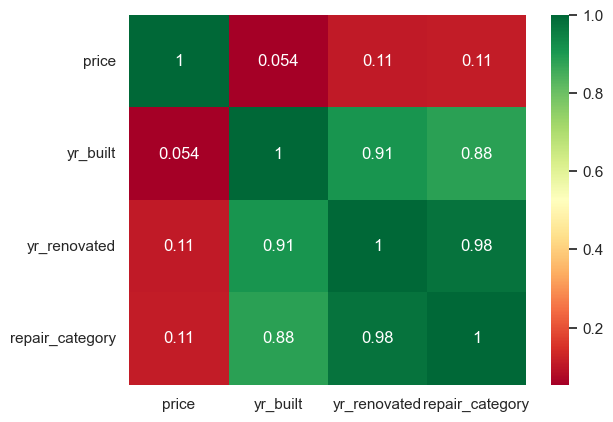

In [33]:
sns.heatmap(df[['price', 'yr_built', 'yr_renovated', 'repair_category']].corr(), annot=True, cmap='RdYlGn');

Таким образом, можно удалить ненужные признаки.

In [34]:
df.drop(columns=['yr_built', 'yr_renovated', 'id', 'zipcode'], inplace=True)
df.info

<bound method DataFrame.info of          price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0      221.900         3       1.00         1180      5650     1.0   
1      538.000         3       2.25         2570      7242     2.0   
2      180.000         2       1.00          770     10000     1.0   
3      604.000         4       3.00         1960      5000     1.0   
4      510.000         3       2.00         1680      8080     1.0   
...        ...       ...        ...          ...       ...     ...   
21608  360.000         3       2.50         1530      1131     3.0   
21609  400.000         4       2.50         2310      5813     2.0   
21610  402.101         2       0.75         1020      1350     2.0   
21611  400.000         3       2.50         1600      2388     2.0   
21612  325.000         2       0.75         1020      1076     2.0   

       waterfront  view  condition  grade  sqft_above  sqft_basement      lat  \
0               0     0          3      7     

### Реализации ансамблей
#### Собственные реализации: Bagging

In [35]:
from sklearn.utils.validation import _num_samples, check_is_fitted
from sklearn.utils import check_X_y
from sklearn.utils.estimator_checks import check_estimator
from sklearn.base import RegressorMixin, BaseEstimator
from sklearn.utils.extmath import stable_cumsum
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import check_random_state

In [36]:
class BaggingRegressorForDecisionTree(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators = 10, random_state = None):
        self.n_estimators = n_estimators
        self.random_state = random_state
    def _set_random_states(self, estimator):
        random_state = check_random_state(self.random_state)
        to_set = {}
        for key in estimator.get_params(deep=True):
            if key == "random_state" or key.endswith("__random_state"):
                to_set[key] = random_state.randint(np.iinfo(np.int32).max)
        estimator.set_params(**to_set)
    def fit(self, X, y):
        self.random_state_ = check_random_state(self.random_state)
        self.estimators_ = []
        X, y = check_X_y(X, y, y_numeric=True)
        for _ in range(self.n_estimators):
            estimator = DecisionTreeRegressor()
            self._set_random_states(estimator)
            random_indices = self.random_state_.choice(len(y), size=len(y))
            X_sample, y_sample = X[random_indices], y[random_indices]
            estimator.fit(X_sample, y_sample)
            self.estimators_.append(estimator)
        self.n_features_in_ = X.shape[1]
        return self
    def predict(self, X):
        check_is_fitted(self)
        predictions = [estimator.predict(X) for estimator in self.estimators_]
        return np.mean(predictions, axis=0)
check_estimator(BaggingRegressorForDecisionTree())

#### Собственные реализации: AdaBoost

In [37]:
class AdaBoostRegressorForDecisionTree(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators = 50, random_state=None):
        self.n_estimators = n_estimators
        self.random_state = random_state

    def _set_random_states(self, estimator):
        random_state = check_random_state(self.random_state)
        to_set = {}
        for key in estimator.get_params(deep=True):
            if key == "random_state" or key.endswith("__random_state"):
                to_set[key] = random_state.randint(np.iinfo(np.int32).max)
        estimator.set_params(**to_set)

    def fit(self, X, y):
        self.random_state_ = check_random_state(self.random_state)
        self.estimators_ = []
        self.estimator_weights_ = []

        X, y = check_X_y(X, y, y_numeric=True)

        weights = np.full(len(y), fill_value=(1 / len(y)))
        for _ in range(self.n_estimators):
            estimator = DecisionTreeRegressor()
            self._set_random_states(estimator)
            y_predict = estimator.fit(X, y, sample_weight=weights).predict(X)

            error_vect = np.abs(y_predict - y)
            error_max = error_vect.max()
            if error_max > 0:
                error_vect /= error_max
            estimator_error = np.sum(error_vect * weights)

            if estimator_error <= 0:
                self.estimators_.append(estimator)
                self.estimator_weights_.append(1.0)
                break
            elif estimator_error >= 0.5:
                if len(self.estimators_) == 0:
                    self.estimators_.append(estimator)
                    self.estimator_weights_.append(1.0)
                break

            beta = estimator_error / (1.0 - estimator_error)
            weights *= np.power(beta, (1.0 - error_vect))

            weights /= np.sum(weights)
            self.estimators_.append(estimator)
            self.estimator_weights_.append(np.log(1.0 / beta))

        self._estimator_weights = np.array(self.estimator_weights_)
        self.n_features_in_ = X.shape[1]

        return self

    def predict(self, X):
        check_is_fitted(self)
        predictions = np.array([estimator.predict(X) for estimator in self.estimators_]).T

        sorted_idx = np.argsort(predictions, axis=1)

        weight_cdf = stable_cumsum(self._estimator_weights[sorted_idx], axis=1)
        median_or_above = weight_cdf >= 0.5 * weight_cdf[:, -1][:, np.newaxis]
        median_idx = median_or_above.argmax(axis=1)

        median_estimators = sorted_idx[np.arange(_num_samples(X)), median_idx]

        res = predictions[np.arange(_num_samples(X)), median_estimators]
        return res

check_estimator(AdaBoostRegressorForDecisionTree())

### Подбор гиперпараметров и кросс-валидация (Optuna)

In [38]:
from optuna import create_study
import pathlib
from optuna.samplers import BruteForceSampler
from sklearn.model_selection import cross_validate, KFold
from optuna.integration import OptunaSearchCV

path = pathlib.Path("optuna_results.csv")

def cross_validation(estimator, param_distributions):
    study = create_study(sampler=BruteForceSampler(seed=67), direction="maximize")
    model = OptunaSearchCV(estimator=estimator, param_distributions=param_distributions, scoring='r2', study=study,
                           random_state=56)
    cv_results = cross_validate(model, df.drop(columns=['price']), df['price'], cv=KFold(shuffle=True, random_state=85),
                                scoring=['r2', 'neg_root_mean_squared_error'], n_jobs=3, return_estimator=True)
    for i, fold_estimator in enumerate(cv_results["estimator"], start=1):
        print("Best params #", i, ": ", fold_estimator.best_params_)
    cv_results = pd.DataFrame(cv_results)
    cv_results['estimator'] = estimator.__class__.__name__
    cv_results.to_csv(path, mode="a", header=not path.exists())

#### Bagging

In [39]:
%%time
cross_validation(estimator=BaggingRegressorForDecisionTree(random_state=7), param_distributions={"n_estimators": CategoricalDistribution([5, 25, 50])})

[I 2023-03-28 03:09:05,150] A new study created in memory with name: no-name-b6dfcf3e-7609-4e66-805a-a2815cdee576


Best params # 1 :  {'n_estimators': 50}
Best params # 2 :  {'n_estimators': 50}
Best params # 3 :  {'n_estimators': 50}
Best params # 4 :  {'n_estimators': 50}
Best params # 5 :  {'n_estimators': 50}
CPU times: total: 406 ms
Wall time: 2min 15s


In [40]:
%%time
from sklearn.ensemble import BaggingRegressor
cross_validation(estimator=BaggingRegressor(), param_distributions={"n_estimators": CategoricalDistribution([5, 25, 50])})


[I 2023-03-28 03:11:21,125] A new study created in memory with name: no-name-0a7d704c-5212-4b49-ac8d-e57dd91007e9


Best params # 1 :  {'n_estimators': 50}
Best params # 2 :  {'n_estimators': 50}
Best params # 3 :  {'n_estimators': 50}
Best params # 4 :  {'n_estimators': 50}
Best params # 5 :  {'n_estimators': 50}
CPU times: total: 406 ms
Wall time: 2min 26s


#### AdaBoost

In [41]:
%%time
cross_validation(estimator=AdaBoostRegressorForDecisionTree(random_state=98), param_distributions={"n_estimators": CategoricalDistribution([5, 25, 50])})

[I 2023-03-28 03:13:47,279] A new study created in memory with name: no-name-50896a5c-4761-41f7-9732-e300266aece5


Best params # 1 :  {'n_estimators': 50}
Best params # 2 :  {'n_estimators': 50}
Best params # 3 :  {'n_estimators': 25}
Best params # 4 :  {'n_estimators': 25}
Best params # 5 :  {'n_estimators': 25}
CPU times: total: 109 ms
Wall time: 2min 26s


In [42]:
%%time
from sklearn.ensemble import AdaBoostRegressor
cross_validation(estimator=AdaBoostRegressor(), param_distributions={"learning_rate": CategoricalDistribution([0.01, 0.1, 1]),
                 "n_estimators": CategoricalDistribution([5, 25, 50])})

[I 2023-03-28 03:16:13,810] A new study created in memory with name: no-name-ceb83e5a-99fe-42f1-981d-31536e4780ea


Best params # 1 :  {'learning_rate': 0.1, 'n_estimators': 50}
Best params # 2 :  {'learning_rate': 0.1, 'n_estimators': 50}
Best params # 3 :  {'learning_rate': 0.1, 'n_estimators': 50}
Best params # 4 :  {'learning_rate': 0.1, 'n_estimators': 50}
Best params # 5 :  {'learning_rate': 0.1, 'n_estimators': 50}
CPU times: total: 0 ns
Wall time: 1min 12s


#### Random Forest

In [43]:
%%time
from sklearn.ensemble import RandomForestRegressor
cross_validation(estimator=RandomForestRegressor(), param_distributions={"n_estimators": CategoricalDistribution([10, 50, 100])})

[I 2023-03-28 03:17:26,258] A new study created in memory with name: no-name-d093be48-ebf5-4c5b-8a0a-4c85a5fbde2c


Best params # 1 :  {'n_estimators': 100}
Best params # 2 :  {'n_estimators': 100}
Best params # 3 :  {'n_estimators': 100}
Best params # 4 :  {'n_estimators': 100}
Best params # 5 :  {'n_estimators': 100}
CPU times: total: 812 ms
Wall time: 4min 52s


#### GradientBoosting

In [44]:
%%time
from sklearn.ensemble import GradientBoostingRegressor
cross_validation(estimator=GradientBoostingRegressor(), param_distributions={"learning_rate": CategoricalDistribution([0.01, 0.1, 1]),
                 "n_estimators": CategoricalDistribution([5, 25, 50]), "max_leaf_nodes": CategoricalDistribution([10, 100])})

[I 2023-03-28 03:22:18,921] A new study created in memory with name: no-name-d9fd3ea1-a383-41e1-98d0-840b80f03094


Best params # 1 :  {'learning_rate': 1, 'n_estimators': 25, 'max_leaf_nodes': 10}
Best params # 2 :  {'learning_rate': 1, 'n_estimators': 50, 'max_leaf_nodes': 10}
Best params # 3 :  {'learning_rate': 1, 'n_estimators': 25, 'max_leaf_nodes': 10}
Best params # 4 :  {'learning_rate': 1, 'n_estimators': 50, 'max_leaf_nodes': 10}
Best params # 5 :  {'learning_rate': 1, 'n_estimators': 50, 'max_leaf_nodes': 10}
CPU times: total: 0 ns
Wall time: 1min 9s


#### HistGradientBoosting

In [45]:
%%time
from sklearn.ensemble import HistGradientBoostingRegressor
cross_validation(estimator=HistGradientBoostingRegressor(), param_distributions={"learning_rate": CategoricalDistribution([0.01, 0.1, 1]),
                 "max_iter": CategoricalDistribution([100, 200, 400]), "early_stopping": CategoricalDistribution([False, True])})

[I 2023-03-28 03:23:28,585] A new study created in memory with name: no-name-c5788525-3643-468a-b850-40a9dccb4e56


Best params # 1 :  {'learning_rate': 0.1, 'max_iter': 200, 'early_stopping': False}
Best params # 2 :  {'learning_rate': 0.1, 'max_iter': 200, 'early_stopping': False}
Best params # 3 :  {'learning_rate': 0.1, 'max_iter': 200, 'early_stopping': False}
Best params # 4 :  {'learning_rate': 0.1, 'max_iter': 200, 'early_stopping': False}
Best params # 5 :  {'learning_rate': 0.1, 'max_iter': 200, 'early_stopping': False}
CPU times: total: 31.2 ms
Wall time: 1min 52s


#### XGBoost

In [46]:
%%time
from xgboost import XGBRegressor
cross_validation(estimator=XGBRegressor(n_jobs=2), param_distributions={"learning_rate": CategoricalDistribution([0.01, 0.1, 1]),
                 "n_estimators": CategoricalDistribution([5, 25, 50]), "max_leaves": CategoricalDistribution([10, 20, 30]),
                "tree_method": CategoricalDistribution(["exact", "approx", "hist"])})

[I 2023-03-28 03:25:21,487] A new study created in memory with name: no-name-25f3eeff-53a8-4ecd-a3e9-72aa4344d3ae


Best params # 1 :  {'learning_rate': 0.1, 'n_estimators': 50, 'max_leaves': 10, 'tree_method': 'hist'}
Best params # 2 :  {'learning_rate': 0.1, 'n_estimators': 50, 'max_leaves': 10, 'tree_method': 'hist'}
Best params # 3 :  {'learning_rate': 0.1, 'n_estimators': 50, 'max_leaves': 10, 'tree_method': 'hist'}
Best params # 4 :  {'learning_rate': 0.1, 'n_estimators': 50, 'max_leaves': 10, 'tree_method': 'hist'}
Best params # 5 :  {'learning_rate': 0.1, 'n_estimators': 50, 'max_leaves': 10, 'tree_method': 'hist'}
CPU times: total: 1.5 s
Wall time: 11 s


#### LightGBM

In [47]:
%%time
from lightgbm import LGBMRegressor
cross_validation(estimator=LGBMRegressor(), param_distributions={"learning_rate": CategoricalDistribution([0.01, 0.1, 1]),
                 "n_estimators": CategoricalDistribution([5, 25, 50]), "num_leaves": CategoricalDistribution([10, 20, 30])})

[I 2023-03-28 03:25:32,470] A new study created in memory with name: no-name-0f8b94d5-21b2-4589-a660-1080373161f5


Best params # 1 :  {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 20}
Best params # 2 :  {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 20}
Best params # 3 :  {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 20}
Best params # 4 :  {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 20}
Best params # 5 :  {'learning_rate': 0.1, 'n_estimators': 50, 'num_leaves': 20}
CPU times: total: 2.3 s
Wall time: 6.39 s


#### CatBoost

In [48]:
%%time
from catboost import CatBoostRegressor
cross_validation(estimator=CatBoostRegressor(), param_distributions={"n_estimators": CategoricalDistribution([100, 300, 600])})

[I 2023-03-28 03:25:38,880] A new study created in memory with name: no-name-cf184fe2-0ac8-414b-a1aa-61785d65c476


Best params # 1 :  {'n_estimators': 600}
Best params # 2 :  {'n_estimators': 600}
Best params # 3 :  {'n_estimators': 600}
Best params # 4 :  {'n_estimators': 600}
Best params # 5 :  {'n_estimators': 600}
CPU times: total: 0 ns
Wall time: 52.4 s


### Результаты

In [49]:
cv_results = pd.read_csv(path)
cv_results['test_neg_root_mean_squared_error'] *= -1

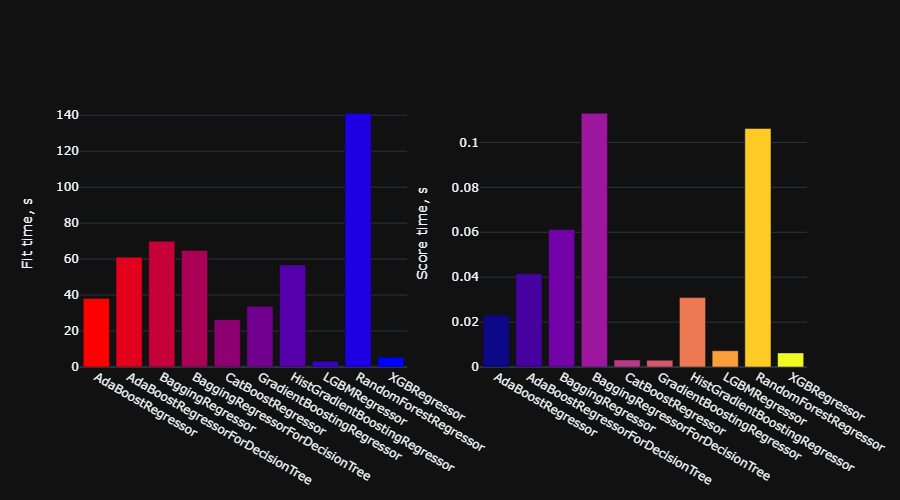

In [50]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
data = cv_results.groupby("estimator", as_index=False).mean()
fig = make_subplots(rows=1, cols=2)
fig.add_trace(go.Bar(x=data['estimator'],y=data['fit_time'], marker=dict(color=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], coloraxis="coloraxis")), row=1, col=1)
fig.add_trace(go.Bar(x=data['estimator'], y=data['score_time'], marker=dict(color=[11, 12, 13, 14, 15, 16, 17, 18, 19, 20])), row=1, col=2)
fig.update_yaxes(title_text="Fit time, s", row=1, col=1)
fig.update_yaxes(title_text="Score time, s", row=1, col=2)
fig.update_layout(width=900, coloraxis=dict(colorscale='Bluered_r'), showlegend=False, coloraxis_showscale=False)
fig.show("png")

Из графиков и предыдущих замеров можно сделать вывод, что больше всего времени для работы понадобилось алгоритму `RandomForest`.
Быстрее же всех остальных отработали `LGBMRegressor` и `XGBRegressor`.

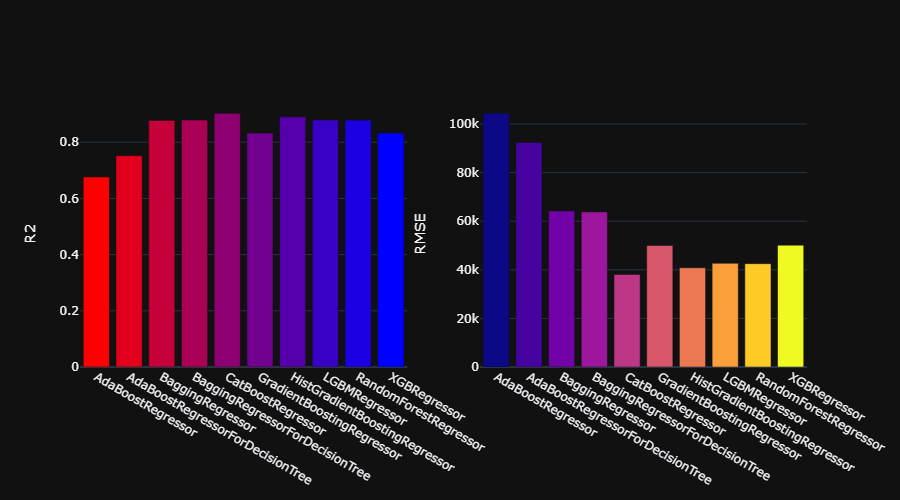

In [51]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
data = cv_results.groupby("estimator", as_index=False).mean()
fig = make_subplots(rows=1, cols=2)
fig.add_trace(go.Bar(x=data['estimator'],y=data['test_r2'], marker=dict(color=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], coloraxis="coloraxis")), row=1, col=1)
fig.add_trace(go.Bar(x=data['estimator'], y=data['test_neg_root_mean_squared_error'], marker=dict(color=[11, 12, 13, 14, 15, 16, 17, 18, 19, 20])), row=1, col=2)
fig.update_yaxes(title_text="R2", row=1, col=1)
fig.update_yaxes(title_text="RMSE", row=1, col=2)
fig.update_layout(width=900, coloraxis=dict(colorscale='Bluered_r'), showlegend=False, coloraxis_showscale=False)
fig.show("png")

Наиболее точным по коэффициенту детерминации на данном датасете оказался `CatBoost`, что также подтверждается наименьшей среднеквадратичной ошибкой.
Худшим из представленных можно назвать `AdaBoost`.

Но по итогу все модели показали довольно неплохой результат, возможно, из-за удачно подобранных данных.

